In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from google.colab import drive
import sys, os, shutil
from pathlib import Path
drive.mount("/content/drive", force_remount=True)
colabase = Path('/content/drive/My Drive/Colab Notebooks/')
course = Path('/content/drive/My Drive/course-v3/')
dlff = Path('/content/drive/My Drive/deeplearning-ff/')
#sys.path.append(str(dlff)) # cd {dlff}
os.chdir(dlff)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mounted at /content/drive


In [0]:
#export
from exports.lg_10c import *

## Imagenet(te) training

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=1681)

In [0]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [0]:
size = 128
tfms = [make_rgb, RandomResizedCrop(size, scale=(0.35,1)), np_to_float, PilRandomFlip()]

bs = 64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

ll.valid.x.tfms = [make_rgb, CenterCrop(size), np_to_float]

data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=8)

## XResNet

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=1701)

In [0]:
#export
def noop(x): return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

In [0]:
#export
act_fn = nn.ReLU(inplace=True)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.) 
    # bag of tricks, like identity in that block when init
    # so we can have high learning rate 
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

In [0]:
#export
class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False) # add conv to match size, in necessary  
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True) # add AvgPool if stride 2 was used, to match size

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

In [0]:
#export
class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=1000):
        nfs = [c_in, (c_in+1)*8, 64, 64]
        stem = [conv_layer(nfs[i], nfs[i+1], stride=2 if i==0 else 1)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        res = cls(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *res_layers,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(nfs[-1]*expansion, c_out),
        )
        init_cnn(res)
        return res

    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(n_blocks)])

In [0]:
#export
def xresnet18 (**kwargs): return XResNet.create(1, [2, 2,  2, 2], **kwargs)
def xresnet34 (**kwargs): return XResNet.create(1, [3, 4,  6, 3], **kwargs)
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs) #expansion 4 for 50 and over
def xresnet101(**kwargs): return XResNet.create(4, [3, 4, 23, 3], **kwargs)
def xresnet152(**kwargs): return XResNet.create(4, [3, 8, 36, 3], **kwargs)

## Train

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=2515)

In [0]:
cbfs = [partial(AvgStatsCallback,accuracy), ProgressCallback, CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette),
#         partial(MixUp, alpha=0.2)
       ]

In [0]:
loss_func = LabelSmoothingCrossEntropy() # always good idea, unless u know ur labels are perfect
arch = partial(xresnet18, c_out=10)
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [0]:
#export
def get_batch(dl, learn):
    learn.xb,learn.yb = next(iter(dl))
    learn.do_begin_fit(0)
    learn('begin_batch')
    learn('after_fit')
    return learn.xb,learn.yb

We need to replace the old `model_summary` since it used to take a `Runner`.

In [0]:
# export
def model_summary(model, data, find_all=False, print_mod=False):
    """Summary with Learner without runner"""
    xb,yb = get_batch(data.valid_dl, learn)
    mods = find_modules(model, is_lin_layer) if find_all else model.children()
    f = lambda hook,mod,inp,out: print(f"====\n{mod}\n" if print_mod else "", out.shape)
    with Hooks(mods, f) as hooks: learn.model(xb)

In [0]:
learn = Learner(arch(), data, loss_func, lr=1, cb_funcs=cbfs, opt_func=opt_func)

In [33]:
learn.model = learn.model.cuda()
model_summary(learn.model, data, print_mod=False) #True to see full summary, False to see only sizes

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


 torch.Size([128, 32, 64, 64])
 torch.Size([128, 64, 64, 64])
 torch.Size([128, 64, 64, 64])
 torch.Size([128, 64, 32, 32])
 torch.Size([128, 64, 32, 32])
 torch.Size([128, 128, 16, 16])
 torch.Size([128, 256, 8, 8])
 torch.Size([128, 512, 4, 4])
 torch.Size([128, 512, 1, 1])
 torch.Size([128, 512])
 torch.Size([128, 10])


In [0]:
arch = partial(xresnet34, c_out=10)

In [0]:
learn = Learner(arch(), data, loss_func, lr=1, cb_funcs=cbfs, opt_func=opt_func)

In [60]:
learn.fit(1, cbs=[LR_Find(), Recorder()])

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


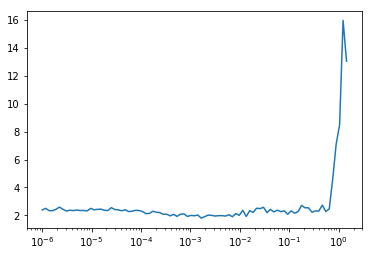

In [20]:
learn.recorder.plot(3)

In [0]:
#export
def create_phases(phases):
    """Create phases for scheduler"""
    phases = listify(phases)
    return phases + [1-sum(phases)]

In [22]:
print(create_phases(0.3))
print(create_phases([0.3,0.2]))

[0.3, 0.7]
[0.3, 0.2, 0.5]


In [0]:
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

In [0]:
cbsched = [
    ParamScheduler('lr', sched_lr),
    ParamScheduler('mom', sched_mom)]

In [0]:
learn = Learner(arch(), data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func) # only call back funcs at creation

In [26]:
learn.fit(5, cbs=cbsched) #u can pass 'raw' callbacks to fit function now

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.693358,0.492322,2.100544,0.410000,01:04
1,1.462343,0.603226,1.519087,0.558000,01:03
2,1.313797,0.664573,1.366862,0.608000,01:03
3,1.137794,0.738095,0.961355,0.810000,01:04
4,0.978105,0.804328,0.890601,0.844000,01:04


## cnn_learner

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=2711)

In [0]:
#export
def cnn_learner(arch, data, loss_func, opt_func, c_in=None, c_out=None,
                lr=1e-2, cuda=True, norm=None, progress=True, mixup=0, xtra_cb=None, **kwargs):
    cbfs = [partial(AvgStatsCallback,accuracy)]+listify(xtra_cb)
    if progress: cbfs.append(ProgressCallback)
    if cuda:     cbfs.append(CudaCallback)
    if norm:     cbfs.append(partial(BatchTransformXCallback, norm))
    if mixup:    cbfs.append(partial(MixUp, mixup))
    arch_args = {}
    if not c_in : c_in  = data.c_in
    if not c_out: c_out = data.c_out
    if c_in:  arch_args['c_in' ]=c_in
    if c_out: arch_args['c_out']=c_out
    return Learner(arch(**arch_args), data, loss_func, opt_func=opt_func, lr=lr, cb_funcs=cbfs, **kwargs)

In [0]:
learn = cnn_learner(xresnet34, data, loss_func, opt_func, norm=norm_imagenette)

In [29]:
learn.fit(5, cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.665459,0.508066,1.836913,0.502000,01:04
1,1.431809,0.615868,1.508829,0.596000,01:04
2,1.316600,0.660695,2.009334,0.426000,01:04
3,1.154969,0.730495,1.061450,0.778000,01:04
4,0.977766,0.802389,0.888498,0.846000,01:04


In [0]:
# def lamb_optim(xtra_step=None, **kwargs):
#     return partial(StatefulOptimizer, steppers=[lamb_step]+listify(xtra_step),
#                    stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()], **kwargs)

In [0]:
# opt_lamb = lamb_optim(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [0]:
# cbf2 = [partial(AvgStatsCallback,accuracy), ProgressCallback, CudaCallback,
#         partial(BatchTransformXCallback, norm_imagenette)     ]

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


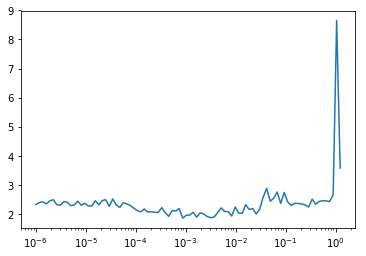

In [68]:
# learnR = Learner(arch(), data, loss_func, lr=1e-2, cb_funcs=cbf2, opt_func=opt_lamb)
# learnR.fit(1, cbs=[LR_Find(), Recorder()])
# learnR.recorder.plot(5)

In [0]:
# lr2 = 3e-2
# pct_start2 = 0.5
# phases2 = create_phases(pct_start2)
# sched_lr2  = combine_scheds(phases2, cos_1cycle_anneal(lr2/10., lr2, lr2/1e5))
# sched_mom2 = combine_scheds(phases2, cos_1cycle_anneal(0.95, 0.85, 0.95))

In [0]:
# cbsched2 = [
#     ParamScheduler('lr', sched_lr2),
#     ParamScheduler('mom', sched_mom2)]

In [0]:
# learn_lamb = cnn_learner(xresnet34, data, loss_func, opt_lamb, norm=norm_imagenette)
# learn_lamb.fit(5, cbsched2)

## Imagenet

You can see all this put together in the fastai [imagenet training script](https://github.com/fastai/fastai/blob/master/examples/train_imagenet.py). It's the same as what we've seen so far, except it also handles multi-GPU training. So how well does this work?

We trained for 60 epochs, and got an error of 5.9%, compared to the official PyTorch resnet which gets 7.5% error in 90 epochs! Our xresnet 50 training even surpasses standard resnet 152, which trains for 50% more epochs and has 3x as many layers.

## Export

In [31]:
! python notebook2script.py 11_train_imagenette.ipynb

Converted 11_train_imagenette.ipynb to exports/lg_11.py
